In [10]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/2Spin`


In [22]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, LaTeXStrings, JLD2, Statistics, Interpolations
import PyPlot as plt
using PyCall, Conda

const mlines_plt = pyimport("matplotlib.lines")
Line2D = mlines_plt.Line2D # For custom legends

PyObject <class 'matplotlib.lines.Line2D'>

In [21]:
function gen_J(N, K, J_params; rng=Xoshiro(1234))
    J = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
    @inbounds @fastmath for i in 1:N
        @inbounds @fastmath for j in i+1:N
            if J[i, j] ≠ 0
                Jval = J_params[1]/sqrt(K) * (rand(rng) < 0.5 ? 1 : -1)
                J[i, j] = Jval
                J[j, i] = Jval
            end
        end
    end
    dropzeros!(J)
    return J
end

"""
    running_logavg(x, y; halfdecade=0.1)

Compute a running (moving) average of `y` against `x` in log–log space.

# Arguments
- `x::AbstractVector{<:Real}`:  abscissae (must be > 0)
- `y::AbstractVector{<:Real}`:  ordinates (must be > 0)
- `halfdecade::Real=0.1`: half–width of the smoothing window in decades of `x`
    (i.e. window spans ± `halfdecade` in `log10(x)`)

# Returns
- `(xs, ys_smooth)`, where
  - `xs` is the sorted `x`,
  - `ys_smooth[i]` = 10^( mean{ log10(y[j]) : |log10(x[j]) - log10(xs[i])| ≤ halfdecade } ).

Points with `x≤0` or `y≤0` are filtered out automatically.
"""
function running_logavg(x::AbstractVector, y::AbstractVector; halfdecade::Real=0.1)
    # filter positives only
    mask = (x .> 0) .& (y .> 0)
    xpos = x[mask]; ypos = y[mask]

    # sort by x
    idx = sortperm(xpos)
    xs = xpos[idx]
    ys = ypos[idx]

    # log-transforms
    lx = log10.(xs)
    ly = log10.(ys)

    N = length(xs)
    ys_smooth = similar(ys)
    # sliding window in log-space
    for i in 1:N
        # find neighbors within halfdecade
        Δ = abs.(lx .- lx[i])
        local_mask = Δ .<= halfdecade
        # arithmetic mean in log-space
        μ = mean(ly[local_mask])
        ys_smooth[i] = 10.0^μ
    end

    return xs, ys_smooth
end

running_logavg

# Check RS assumption

In [5]:
#############
# Load data #
#############

# Load MC data
N, K = 1000, 5
J, D = 1.0, 0.3
tmax = 2e1
nsim = 10000
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -3.0, 3.0

ilist = [1, 2, 1000]

filename = "data/RRG/Corr_Bim_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, Cs, tidxs= load(filename, "tsave", "autocorrs", "tidxs");

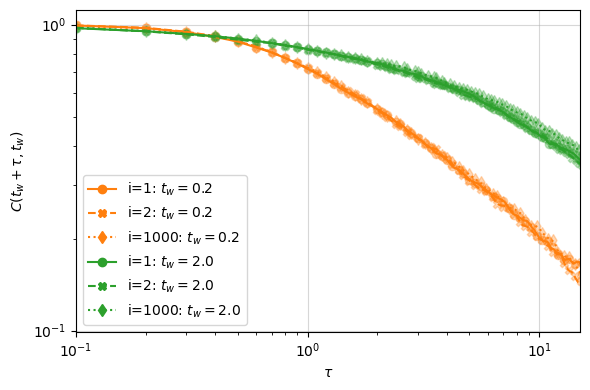

In [8]:
# Plot correlations for the two nodes at different waiting times
tws = collect(10 .^ range(log10(2e-1), stop=log10(2), length=2))

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

markers = ["o", "X", "d"]
lstyles = ["-", "--", ":"]
# Iterate over the waiting times
for (i, tw) in enumerate(tws)
    for (idx, inode) in enumerate(ilist)
        tvec = tsave[tidxs[idx]]
        C_mc = Cs[idx]
        # Get the corresponding indices (your existing code)
        tw_idx = argmin(abs.(tvec .- tw))
        tw = tvec[tw_idx]
        # Get unique indices for log-spaced sampling (your existing code)
        imin, imax = tw_idx, length(tvec)
        logmin, logmax = log10(imin), log10(imax)
        indices = round.(Int, exp10.(range(logmin, logmax, length=80)))
        unique_indices = unique(indices[indices .>= imin .&& indices .<= imax])
        # Plot the first node's correlation
        ax.scatter(tvec[unique_indices] .- tw, C_mc[unique_indices, tw_idx] ./ C_mc[tw_idx, tw_idx], color="C$i", alpha=0.3, marker=markers[idx])
        # smooth with a ±0.2‐decade window
        xs, ys_s = running_logavg(tvec[tw_idx:end] .- tw, C_mc[tw_idx:end, tw_idx] ./ C_mc[tw_idx, tw_idx]; halfdecade=.01)
        ax.plot(xs, ys_s, color="C$i", ls=lstyles[idx])

        ax.plot([], [], color="C$i", marker=markers[idx], ls=lstyles[idx], label="i=$inode: "*L"t_w=" *"$(round(tw, digits=3))")  # for legend
    end
end

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1, 1.5e1)
#ax.set_ylim(8e-2, 1.2)
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=.5)
ax.legend()

plt.display(fig)

# Save the figure
plt.savefig("Check_RS_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_RS_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

# Check aging on Ferro

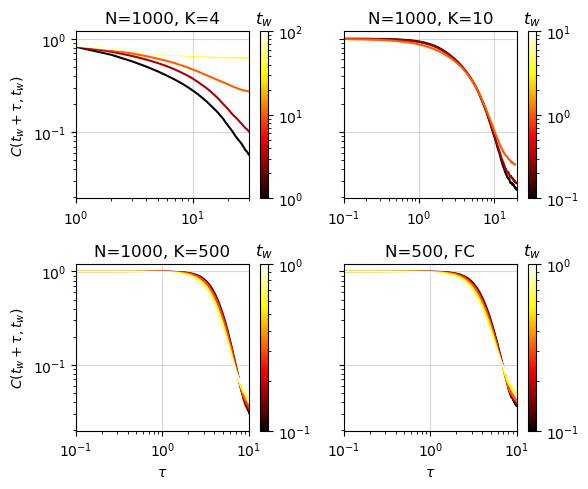

In [6]:
# Plot all together
fig, axs = plt.subplots(2, 2, figsize=(6, 5), tight_layout=true, sharey=true)

###############
# N=1000, K=4 #
###############
N, K = 1000, 4
J, D = 1.0, 0.3
tmax = 2e2
dt = 1e-2
dt_save = 1.0
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1.0), stop=log10(1e2), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[1,1]

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e0, 3e1)
ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.set_title("N=1000, K=4")


################
# N=1000, K=10 #
################
N, K = 1000, 10
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e1), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[1, 2]

for (i, tw) in enumerate(tws[1:end-2])
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1,2e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.5)
ax.set_title("N=1000, K=10")


#################
# N=1000, K=500 #
#################
N, K = 1000, 500
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[2, 1]

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")
clb.ax.tick_params(axis="y", which="minor", labelright=false)

# Set scales and labels (your existing code)
ax.set_xlim(1e-1,1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.5)
ax.set_title("N=1000, K=500")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")


#############
# N=500, FC #
#############
N = 500
K = N - 1
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-2
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[2, 2]

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")
clb.ax.tick_params(axis="y", which="minor", labelright=false)

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.grid(alpha=0.5)
ax.set_title("N=500, FC")

plt.display(fig)
plt.savefig("Check_agingFerro_RRG_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

# Compare MC with GECaM

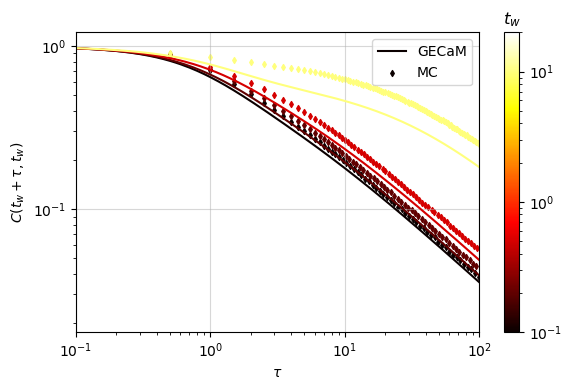

In [14]:
#############
# Load data #
#############

# Load MC data
N = 5000
dt = 1e-1
K = 4
J, D = 1.0, 0.3
tmax = 2e2
nsim = 500
dt_save = 1e-1
nts = 500
x0_min, x0_max = -3.0, 3.0

filename = "data/RRG/Corr_Bim_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, tidxs, Cs_mc = load(filename, "tsave", "tidxs", "autocorrs")

# Load GECaM data
K = 4
J, D = 1.0, 0.3
tmax = 2e2
dt = 5e-2

filename = "data/GECaM_RRG_Bim/Corr_GECaM_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dt-$(dt).jld2"
tvec_G, C_G = load(filename, "tvec_G", "C_G")


# Define tws (logarithmically spaced waiting times)
tws = [1e-1, 2e-1, 5e-1, 1e1, 2e1]

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

########
# Plot #
########

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

markers = ["X", "d"]
for (i, tw) in enumerate(tws[1:end-1])
    # Plot scatter points and line with the same color
    # GECaM
    tw_idx_G = argmin(abs.(tvec_G .- tw)) # find the index of the closest time
    tw_G = tvec_G[tw_idx_G] # get the actual time
    if i == 1
        ax.plot(
            tvec_G[tw_idx_G:end-1] .- tw_G,
            C_G[tw_idx_G:end, tw_idx_G] ./ C_G[tw_idx_G, tw_idx_G],
            color=my_cmap(norm(tw_G)),
            label="GECaM"
        )
    else
        ax.plot(
            tvec_G[tw_idx_G:end-1] .- tw_G,
            C_G[tw_idx_G:end, tw_idx_G] ./ C_G[tw_idx_G, tw_idx_G],
            color=my_cmap(norm(tw_G))
        )
    end

    # MC
    tw_idx_mc = argmin(abs.(tsave .- tw)) # find the index of the closest time
    tw_mc = tsave[tw_idx_mc] # get the actual time
    if i == 1
        ax.scatter(
            tsave[tidxs[i][1:5:end]] .- tw_mc,
            Cs_mc[i][1:5:end] ./ Cs_mc[i][1],
            color=my_cmap(norm(tw_mc)),
            s=9,
            marker="d",
            label="MC"
        )
    else
        ax.scatter(
            tsave[tidxs[i][1:5:end]] .- tw_mc,
            Cs_mc[i][1:5:end] ./ Cs_mc[i][1],
            color=my_cmap(norm(tw_mc)),
            s=9,
            marker="d"
        )
    end
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e2)
#ax.set_ylim(C_mc[argmin(abs.(tvec_mc .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)
fig.savefig("autocorr_RRG_comparison.png", dpi=300)
fig.savefig("autocorr_RRG_comparison.pdf", dpi=300)

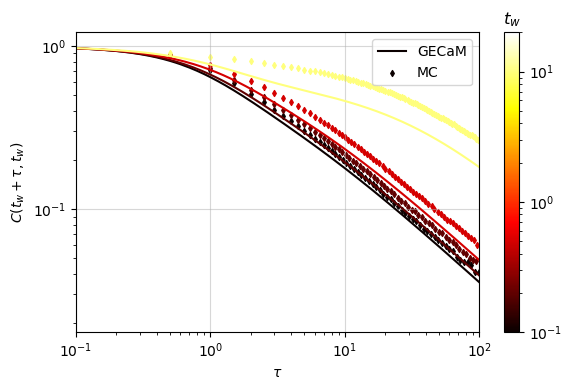

In [15]:
#############
# Load data #
#############

# Load MC data
N = 1000
dt = 1e-2
K = 4
J, D = 1.0, 0.3
tmax = 2e2
nsim = 500
dt_save = 1e-1
nts = 500
x0_min, x0_max = -3.0, 3.0

filename = "data/RRG/Corr_Bim_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, tidxs, Cs_mc = load(filename, "tsave", "tidxs", "autocorrs")

# Load GECaM data
K = 4
J, D = 1.0, 0.3
tmax = 2e2
dt = 5e-2

filename = "data/GECaM_RRG_Bim/Corr_GECaM_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dt-$(dt).jld2"
tvec_G, C_G = load(filename, "tvec_G", "C_G")


# Define tws (logarithmically spaced waiting times)
tws = [1e-1, 2e-1, 5e-1, 1e1, 2e1]

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

########
# Plot #
########

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

markers = ["X", "d"]
for (i, tw) in enumerate(tws[1:end-1])
    # Plot scatter points and line with the same color
    # GECaM
    tw_idx_G = argmin(abs.(tvec_G .- tw)) # find the index of the closest time
    tw_G = tvec_G[tw_idx_G] # get the actual time
    if i == 1
        ax.plot(
            tvec_G[tw_idx_G:end-1] .- tw_G,
            C_G[tw_idx_G:end, tw_idx_G] ./ C_G[tw_idx_G, tw_idx_G],
            color=my_cmap(norm(tw_G)),
            label="GECaM"
        )
    else
        ax.plot(
            tvec_G[tw_idx_G:end-1] .- tw_G,
            C_G[tw_idx_G:end, tw_idx_G] ./ C_G[tw_idx_G, tw_idx_G],
            color=my_cmap(norm(tw_G))
        )
    end

    # MC
    tw_idx_mc = argmin(abs.(tsave .- tw)) # find the index of the closest time
    tw_mc = tsave[tw_idx_mc] # get the actual time
    if i == 1
        ax.scatter(
            tsave[tidxs[i][1:5:end]] .- tw_mc,
            Cs_mc[i][1:5:end] ./ Cs_mc[i][1],
            color=my_cmap(norm(tw_mc)),
            s=9,
            marker="d",
            label="MC"
        )
    else
        ax.scatter(
            tsave[tidxs[i][1:5:end]] .- tw_mc,
            Cs_mc[i][1:5:end] ./ Cs_mc[i][1],
            color=my_cmap(norm(tw_mc)),
            s=9,
            marker="d"
        )
    end
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e2)
#ax.set_ylim(C_mc[argmin(abs.(tvec_mc .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)
fig.savefig("autocorr_RRG_comparison.png", dpi=300)
fig.savefig("autocorr_RRG_comparison.pdf", dpi=300)

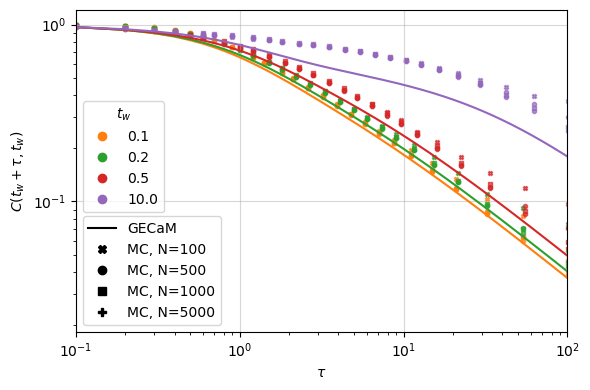

In [65]:
#############
# Load data #
#############

# Load MC data
Ns = [100, 500, 1000, 5000]
dts = [1e-1, 1e-1, 1e-2, 1e-1]
K = 4
J, D = 1.0, 0.3
tmax = 2e2
nsim = 500
dt_save = 1e-1
nts = 500
x0_min, x0_max = -3.0, 3.0

markers = ["X", "o", "s", "P"]

tsaves = []
tidxss = []
Cs_mcs = []

for (N, dt) in zip(Ns, dts)
    filename = "data/RRG/Corr_Bim_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
    tsave, tidxs, Cs_mc = load(filename, "tsave", "tidxs", "autocorrs")
    push!(tsaves, tsave)
    push!(tidxss, tidxs)
    push!(Cs_mcs, Cs_mc)
end

# Load GECaM data
K = 4
J, D = 1.0, 0.3
tmax = 2e2
dt = 0.1

filename = "data/GECaM_RRG_Bim/Corr_GECaM_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dt-$(dt).jld2"
tvec_G, C_G = load(filename, "tvec_G", "C_G")

# Define tws (logarithmically spaced waiting times)
tws = [1e-1, 2e-1, 5e-1, 1e1, 2e1]

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

########
# Plot #
########

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

leg1_obj = PyObject[]
leg2_obj = PyObject[]

for (i, tw) in enumerate(tws[1:end-1])
    push!(leg1_obj, Line2D([], [], color="C$(i)", marker="o", linestyle="none", label="$(tw)"))

    # Plot scatter points and line with the same color
    # GECaM
    tw_idx_G = argmin(abs.(tvec_G .- tw)) # find the index of the closest time
    tw_G = tvec_G[tw_idx_G] # get the actual time
    if i == 1
        push!(leg2_obj, Line2D([], [], color="k", linestyle="-", label="GECaM"))
    end 
    ax.plot(
        tvec_G[tw_idx_G:end-1] .- tw_G,
        C_G[tw_idx_G:end, tw_idx_G] ./ C_G[tw_idx_G, tw_idx_G],
        color="C$i"#my_cmap(norm(tw_G))
    )
    for (iN, (tsave, tidxs, Cs_mc)) in enumerate(zip(tsaves, tidxss, Cs_mcs))
        # MC
        tw_idx_mc = argmin(abs.(tsave .- tw)) # find the index of the closest time
        tw_mc = tsave[tw_idx_mc] # get the actual time
        if i == 1
            push!(leg2_obj, Line2D([], [], color="k", marker=markers[iN], linestyle="none", label="MC, N=$(Ns[iN])"))
        end
        # maintain only 20 log-spaced points
        ntotal = length(tidxs[i])
        idxs_logspaced = round.(Int, exp10.(range(log10(1), log10(ntotal), length=30)))
        unique_idxs = unique(idxs_logspaced[idxs_logspaced .<= ntotal])
        ax.scatter(
            tsave[tidxs[i][unique_idxs]] .- tw_mc,
            Cs_mc[i][unique_idxs] ./ Cs_mc[i][1],
            color="C$i",#my_cmap(norm(tw_G)),
            s=9,
            alpha=0.7,
            marker=markers[iN]
        )
    end
end

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e2)
#ax.set_ylim(C_mc[argmin(abs.(tvec_mc .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
leg1 = ax.legend(handles=leg2_obj, loc="lower left")
leg2 = ax.legend(handles=leg1_obj, title=L"t_w", loc="lower left", bbox_to_anchor=(0, 0.35))
ax.add_artist(leg1)

plt.display(fig)
fig.savefig("autocorr_RRG_comparison.png", dpi=300)
fig.savefig("autocorr_RRG_comparison.pdf", dpi=300)